<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

In [2]:
token = userdata.get("DDM_KEY")

!git clone https://{token}@github.com/florivz/DDM-Project-WS24-25.git

fatal: destination path 'DDM-Project-WS24-25' already exists and is not an empty directory.


# Loading the Data

In [3]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [4]:
gdp_data = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")

# Transforming the data

In [5]:
# def add_zeros(code):
#     if len(code) == 3:
#         return '00' + code
#     elif len(code) == 4:
#         return '0' + code
#     elif len(code) == 1:
#         return '0000' + code
#     return code

In [6]:
# Filling 0 to get same length for all FIPS
# df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
# unique_lengths = df_pattern['FIPS'].apply(len).unique()
# unique_lengths

# df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [7]:
# Merging Occupation Datasets
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head(5)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


In [8]:
# Keeping only the necessary columns

# GDP
df_gdp_filtered = gdp_data.drop(gdp_data[['TableName', 'LineCode', 'Unit', 'Region', '2017', '2018', '2019', '2020', '2021', 'GeoName', 'IndustryClassification', 'Description']], axis=1)
df_gdp_filtered = df_gdp_filtered.rename(columns={'2022': 'current_gdp'})

df_gdp_filtered['FIPS'] = df_gdp_filtered['FIPS'].astype(str)
df_gdp_filtered = df_gdp_filtered[df_gdp_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers --> need it on county level

# Naics Pattern
df_pattern_filtered = df_pattern.drop(columns=['emp_nf', 'qp1_nf', 'qp1', 'ap_nf',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4', 'naics_2', 'State_GEOID',	'County_GEOID'])
df_pattern_filtered = df_pattern_filtered.rename(columns={'DESCRIPTION': 'naics_describtion'})

df_pattern_filtered['FIPS'] = df_pattern_filtered['FIPS'].astype(str)
df_pattern_filtered = df_pattern_filtered[df_pattern_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

# Naics Occupation
df_occupation_filtered = df_occupation.drop(columns=['State_GEOID', 'NAICS_TITLE', 'emp_total_county_naics', 'state_name'])

df_occupation_filtered['FIPS'] = df_occupation_filtered['FIPS'].astype(str)
df_occupation_filtered = df_occupation_filtered[df_occupation_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

In [9]:
# # Define the relevant NAICS code prefixes as strings
# relevant_naics_prefixes = ['21', '23', '31', '32', '33']  # Sectors for Mining, Construction, Manufacturing

# # Convert relevant prefixes to a tuple for startswith
# relevant_naics_prefixes = tuple(relevant_naics_prefixes)

# # Filter df_gdp_filtered
# df_gdp_filtered = df_gdp_filtered[
#     df_gdp_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_pattern_filtered
# df_pattern_filtered = df_pattern_filtered[
#     df_pattern_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_occupation_filtered
# df_occupation_filtered = df_occupation_filtered[
#     df_occupation_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

In [10]:
# Merge the result with df_occupation_filtered on FIPS and naics
df_merged = df_pattern_filtered.merge(
    df_occupation_filtered,
    on=['FIPS', 'naics'],
    how='left',
    suffixes=('', '_occupation')
)

In [11]:
# Group by 'FIPS' and 'naics', then sum the specified columns
df_merged_agg = df_merged.groupby(['FIPS']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp_occupation': 'sum'
}).reset_index()

df_merged_agg.head()

,FIPS,ap,est,emp_occupation
0,10001,9796268,13359,738.645632
1,10003,67501272,55700,4924.714589
2,10005,13877915,20524,1128.509047
3,10999,11262604,3286,344.034119
4,11001,90334261,44029,2590.491348


In [12]:
df_gdp_agg = df_gdp_filtered.groupby('FIPS').agg({
    'current_gdp': 'sum'
}).reset_index()
df_gdp_agg.head()

,FIPS,current_gdp
0,10000,355577213.0
1,10001,22652836.0
2,10003,243477316.0
3,10005,43727204.0
4,11000,574989171.0


In [13]:
df_final = df_merged_agg.merge(
    df_gdp_agg,
    how='left',
    on='FIPS'
)
df_final.head()

,FIPS,ap,est,emp_occupation,current_gdp
0,10001,9796268,13359,738.645632,22652836.0
1,10003,67501272,55700,4924.714589,243477316.0
2,10005,13877915,20524,1128.509047,43727204.0
3,10999,11262604,3286,344.034119,NaN
4,11001,90334261,44029,2590.491348,574989171.0


In [14]:
df_final.head()

,FIPS,ap,est,emp_occupation,current_gdp
0,10001,9796268,13359,738.645632,22652836.0
1,10003,67501272,55700,4924.714589,243477316.0
2,10005,13877915,20524,1128.509047,43727204.0
3,10999,11262604,3286,344.034119,NaN
4,11001,90334261,44029,2590.491348,574989171.0


# Data Preprocessing

In [15]:
df_final = df_final.copy()

In [16]:
# Impute Missing GDP with 0
df_final['current_gdp'].fillna(0, inplace=True)

<ipython-input-16-7ad58ba57b88>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['current_gdp'].fillna(0, inplace=True)


In [17]:
# Choosing relevant features
features = ['ap', 'est', 'emp_occupation', 'current_gdp']
X = df_final[features]

In [18]:
# Scaling the data to make them comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

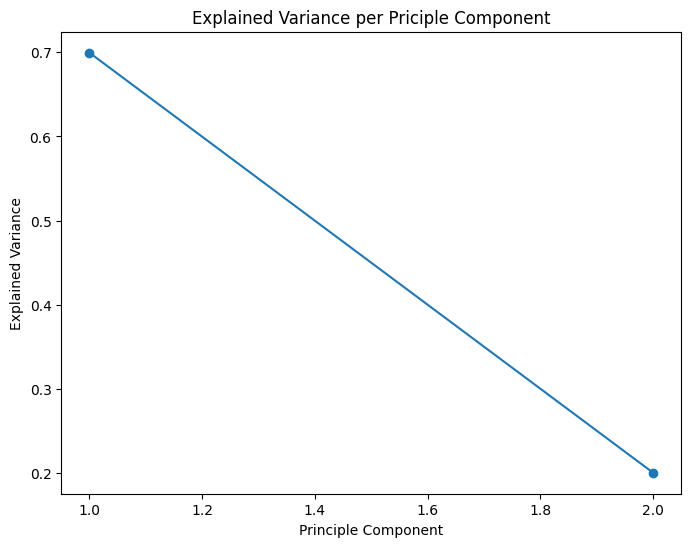

In [19]:
pca = PCA(n_components=2) # the elbow method showed 2 PC are best
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance per Priciple Component')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance')
plt.show()

# Clustering

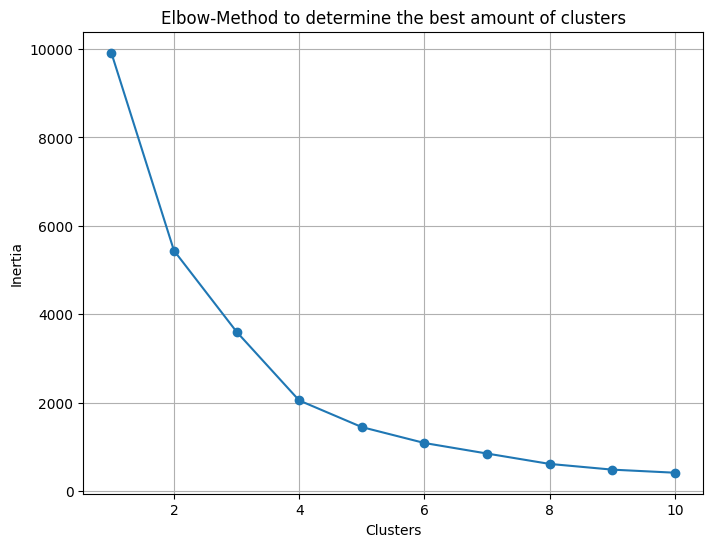

In [20]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Elbow-Method to visualize
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow-Method to determine the best amount of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


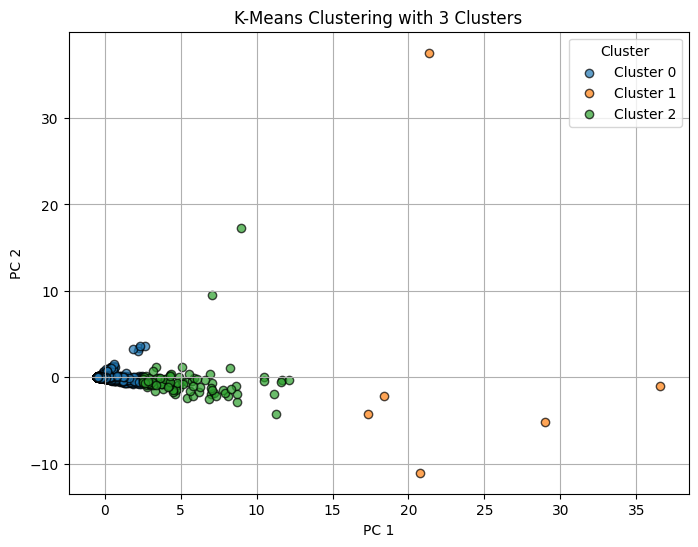

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_final['cluster'] = clusters

plt.figure(figsize=(8, 6))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_pca[clusters == cluster_label, 0],
        X_pca[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        edgecolors='k'
    )

plt.title('K-Means Clustering with 3 Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Interpretation

In [22]:
df_final.head()

,FIPS,ap,est,emp_occupation,current_gdp,cluster
0,10001,9796268,13359,738.645632,22652836.0,0
1,10003,67501272,55700,4924.714589,243477316.0,0
2,10005,13877915,20524,1128.509047,43727204.0,0
3,10999,11262604,3286,344.034119,0.0,0
4,11001,90334261,44029,2590.491348,574989171.0,2


In [23]:
cluster_summary = df_final.groupby('cluster')[['ap', 'est', 'emp_occupation', 'current_gdp']].mean()
print(cluster_summary)

                   ap            est  emp_occupation   current_gdp
cluster                                                           
0        7.229324e+06    5167.117691      844.781829  1.259364e+07
1        1.365648e+09  276280.500000    67275.378041  1.835630e+09
2        1.790928e+08   97550.704082    17370.523175  3.286983e+08


In [25]:
best_cluster = cluster_summary['emp_occupation'].idxmax()  # Cluster with highest emp_occ
best_counties = df_final[df_final['cluster'] == best_cluster]
print(best_counties[['FIPS', 'ap', 'est', 'emp_occupation', 'current_gdp', 'cluster']])

       FIPS          ap     est  emp_occupation   current_gdp  cluster
72    12999  4947868033   27793    59343.781627  0.000000e+00        1
288   17031   681610953  474188    90402.207305  1.998678e+09        1
1502  36061   371273751  162894     9407.711206  3.812610e+09        1
2205  48113   600274600  263376    54220.477443  1.449368e+09        1
2243  48201  1100023035  478591   154640.551796  1.955070e+09        1
2582  53033   492838036  250841    35637.538872  1.798052e+09        1


In [26]:
df_result = df_final[df_final['cluster']==1]
df_result.head()

,FIPS,ap,est,emp_occupation,current_gdp,cluster
72,12999,4947868033,27793,59343.781627,0.000000e+00,1
288,17031,681610953,474188,90402.207305,1.998678e+09,1
1502,36061,371273751,162894,9407.711206,3.812610e+09,1
2205,48113,600274600,263376,54220.477443,1.449368e+09,1
2243,48201,1100023035,478591,154640.551796,1.955070e+09,1


In [27]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 72 to 2582
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FIPS            6 non-null      object 
 1   ap              6 non-null      int64  
 2   est             6 non-null      int64  
 3   emp_occupation  6 non-null      float64
 4   current_gdp     6 non-null      float64
 5   cluster         6 non-null      int32  
dtypes: float64(2), int32(1), int64(2), object(1)
memory usage: 312.0+ bytes
